In [143]:
import pandas as pd
import math
import keras
from keras.layers import Dense,Embedding, Flatten, Conv1D, GlobalMaxPooling1D, LSTM, Bidirectional
from keras.preprocessing.text import text_to_word_sequence,Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [144]:
df = pd.read_pickle("./cryptic_dataset/combined_fifteen_times_final.pickle").drop_duplicates()

In [145]:
cc_types = "is_anagram	is_homophone	is_double	is_cryptic	is_contain	is_reverse	is_alternate	is_init	is_delete	is_charade	is_&lit	is_hidden	is_spoonerism	is_palindrome".split('	')

In [146]:
# df.clue = df.clue.apply(text_to_word_sequence)

In [147]:
cc_types_dfs = [df[df[cc_type]==True] for cc_type in cc_types]

In [148]:
for cc_type,cc_type_df in zip(cc_types,cc_types_dfs):
    cc_type_df['category'] = cc_type

C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [151]:
len(cc_types_dfs)

14

In [152]:
def get_input_val_test(df):
    length = len(df)
    input_len = math.floor(length*0.7)
    val_len  = math.floor(length*0.2)
    test_len = math.floor(length*0.1)
    input_df = df[:input_len]
    val_df = df[input_len:input_len+val_len]
    test_df = df[input_len+val_len:]
    return input_df,val_df,test_df

In [169]:
input_cc_types_df = pd.concat([get_input_val_test(df)[0] for df in cc_types_dfs])
val_cc_types_df = pd.concat([get_input_val_test(df)[1] for df in cc_types_dfs])
test_cc_types_df = pd.concat([get_input_val_test(df)[2] for df in cc_types_dfs])

In [170]:
max_size = input_cc_types_df.groupby('category').count().max()[0]

In [176]:
lst = [input_cc_types_df]
for class_index, group in input_cc_types_df.groupby('category'):
    sample = group.sample(max_size-len(group), replace=True, )
    lst.append(sample)
upsampled_input_cc_types_df = pd.concat(lst)

In [179]:
cc_input_df = upsampled_input_cc_types_df.drop('category',axis=1)
cc_val_df = val_cc_types_df.drop('category',axis=1).drop_duplicates()
cc_test_df = test_cc_types_df.drop('category',axis=1).drop_duplicates()

In [180]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.clue.tolist())
cc_input_data = pad_sequences(tokenizer.texts_to_sequences(cc_input_df.clue.tolist()),maxlen=15)
cc_val_data = pad_sequences(tokenizer.texts_to_sequences(cc_val_df.clue.tolist()),maxlen=15)
cc_test_data = pad_sequences(tokenizer.texts_to_sequences(cc_test_df.clue.tolist()),maxlen=15)

In [181]:
cc_input_data_out = cc_input_df[cc_input_df.columns[2:]] * 1
cc_val_data_out = cc_val_df[cc_val_df.columns[2:]] * 1
cc_test_data_out = cc_test_df[cc_test_df.columns[2:]] * 1

In [182]:
vocab_size = len(tokenizer.word_index) + 1

In [183]:
model = keras.Sequential()
# model.add(Embedding(vocab_size, 300))
model.add(Dense(14, activation='relu', input_dim=15))
model.add(Dense(14, activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['categorical_accuracy'])

In [184]:
history = model.fit(cc_input_data,cc_input_data_out ,validation_data=(cc_val_data,cc_val_data_out), batch_size=128, epochs=6)

Train on 358484 samples, validate on 16926 samples
Epoch 1/6
358484/358484 [==============================] - 10s 29us/step - loss: 2.7302 - categorical_accuracy: 0.1644 - val_loss: 1.9284 - val_categorical_accuracy: 0.2269
Epoch 2/6
358484/358484 [==============================] - 9s 25us/step - loss: 2.3165 - categorical_accuracy: 0.1818 - val_loss: 1.9150 - val_categorical_accuracy: 0.2309
Epoch 3/6
358484/358484 [==============================] - 9s 25us/step - loss: 2.3106 - categorical_accuracy: 0.1839 - val_loss: 1.9104 - val_categorical_accuracy: 0.2311
Epoch 4/6
358484/358484 [==============================] - 9s 25us/step - loss: 2.3088 - categorical_accuracy: 0.1843 - val_loss: 1.9127 - val_categorical_accuracy: 0.2330
Epoch 5/6
358484/358484 [==============================] - 9s 25us/step - loss: 2.3096 - categorical_accuracy: 0.1859 - val_loss: 1.9100 - val_categorical_accuracy: 0.2333
Epoch 6/6
358484/358484 [==============================] - 9s 25us/step - loss: 2.3093 -

In [185]:
model.evaluate(x=cc_test_data, y=cc_test_data_out, batch_size=None, verbose=1, sample_weight=None, steps=None)

8475/8475 [==============================] - 0s 46us/step


[1.8900460505415204, 0.22938053097345132]

In [217]:
model = keras.Sequential()
# model.add(Embedding(vocab_size, 300,input_length=15))
model.add(Dense(300, activation='relu', input_dim=15))
model.add(Dense(14, activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

In [218]:
history = model.fit(cc_input_data,cc_input_data_out ,validation_data=(cc_val_data,cc_val_data_out), batch_size=128, epochs=4)

Train on 711924 samples, validate on 42542 samples
Epoch 1/4
711924/711924 [==============================] - 11s 16us/step - loss: 2.7505 - categorical_accuracy: 0.3063 - val_loss: 2.6746 - val_categorical_accuracy: 0.2312
Epoch 2/4
711924/711924 [==============================] - 10s 15us/step - loss: 2.7355 - categorical_accuracy: 0.3131 - val_loss: 2.6953 - val_categorical_accuracy: 0.2227
Epoch 3/4
711924/711924 [==============================] - 10s 15us/step - loss: 2.7349 - categorical_accuracy: 0.3134 - val_loss: 2.6953 - val_categorical_accuracy: 0.2227
Epoch 4/4
711924/711924 [==============================] - 10s 15us/step - loss: 2.7349 - categorical_accuracy: 0.3134 - val_loss: 2.6953 - val_categorical_accuracy: 0.2227


In [216]:
model.evaluate(x=cc_test_data, y=cc_test_data_out, batch_size=None, verbose=1, sample_weight=None, steps=None)

16968/16968 [==============================] - 0s 17us/step


[2.777652508467225, 0.31347241867043846]

In [429]:
model = keras.Sequential()
# model.add(Embedding(vocab_size, 300,input_length=15))
model.add(Dense(300, activation='sigmoid', input_dim=15))
model.add(Dense(300, activation='sigmoid'))
model.add(Dense(14, activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

In [430]:
history = model.fit(cc_input_data,cc_input_data_out ,validation_data=(cc_val_data,cc_val_data_out), batch_size=128, epochs=4)

Train on 480706 samples, validate on 16926 samples
Epoch 1/4
480706/480706 [==============================] - 12s 26us/step - loss: 0.3623 - categorical_accuracy: 0.2733 - val_loss: 0.3074 - val_categorical_accuracy: 0.2127
Epoch 2/4
480706/480706 [==============================] - 12s 25us/step - loss: 0.3528 - categorical_accuracy: 0.2822 - val_loss: 0.3024 - val_categorical_accuracy: 0.3311
Epoch 3/4
480706/480706 [==============================] - 12s 25us/step - loss: 0.3464 - categorical_accuracy: 0.2847 - val_loss: 0.3041 - val_categorical_accuracy: 0.3002
Epoch 4/4
480706/480706 [==============================] - 12s 25us/step - loss: 0.3408 - categorical_accuracy: 0.2881 - val_loss: 0.3029 - val_categorical_accuracy: 0.2917


In [431]:
model = keras.Sequential()
# model.add(Embedding(vocab_size, 300,input_length=15))
model.add(Dense(300, activation='sigmoid', input_dim=15))
model.add(Dense(300, activation='sigmoid'))
model.add(Dense(300, activation='sigmoid'))
model.add(Dense(14, activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

In [432]:
history = model.fit(cc_input_data,cc_input_data_out ,validation_data=(cc_val_data,cc_val_data_out), batch_size=128, epochs=4)

Train on 480706 samples, validate on 16926 samples
Epoch 1/4
480706/480706 [==============================] - 17s 35us/step - loss: 0.3612 - categorical_accuracy: 0.2776 - val_loss: 0.3047 - val_categorical_accuracy: 0.3257
Epoch 2/4
480706/480706 [==============================] - 16s 33us/step - loss: 0.3472 - categorical_accuracy: 0.2888 - val_loss: 0.3023 - val_categorical_accuracy: 0.2896
Epoch 3/4
480706/480706 [==============================] - 16s 33us/step - loss: 0.3392 - categorical_accuracy: 0.2916 - val_loss: 0.3045 - val_categorical_accuracy: 0.3026
Epoch 4/4
480706/480706 [==============================] - 16s 33us/step - loss: 0.3315 - categorical_accuracy: 0.2933 - val_loss: 0.3047 - val_categorical_accuracy: 0.3212


In [446]:
model = keras.Sequential()
model.add(Embedding(vocab_size, 10,input_length=15))
model.add(Flatten())
model.add(Dense(30, activation='sigmoid'))
model.add(Dense(14, activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

In [447]:
history = model.fit(cc_input_data,cc_input_data_out ,validation_data=(cc_val_data,cc_val_data_out), batch_size=256, epochs=4)

Train on 480706 samples, validate on 16926 samples
Epoch 1/4
480706/480706 [==============================] - 9s 18us/step - loss: 0.3121 - categorical_accuracy: 0.3606 - val_loss: 0.2770 - val_categorical_accuracy: 0.3414
Epoch 2/4
480706/480706 [==============================] - 8s 16us/step - loss: 0.1623 - categorical_accuracy: 0.5833 - val_loss: 0.3133 - val_categorical_accuracy: 0.3344
Epoch 3/4
480706/480706 [==============================] - 8s 16us/step - loss: 0.1039 - categorical_accuracy: 0.6364 - val_loss: 0.3685 - val_categorical_accuracy: 0.3245
Epoch 4/4
480706/480706 [==============================] - 8s 16us/step - loss: 0.0760 - categorical_accuracy: 0.6496 - val_loss: 0.4256 - val_categorical_accuracy: 0.3246


In [471]:
model = keras.Sequential()
model.add(Embedding(vocab_size, 10,input_length=15))
model.add(Conv1D(filters=15,kernel_size=2))
model.add(GlobalMaxPooling1D())
model.add(Dense(30, activation='sigmoid'))
model.add(Dense(14, activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

In [472]:
history = model.fit(cc_input_data,cc_input_data_out ,validation_data=(cc_val_data,cc_val_data_out), batch_size=256, epochs=4)

Train on 480706 samples, validate on 16926 samples
Epoch 1/4
480706/480706 [==============================] - 13s 28us/step - loss: 0.3132 - categorical_accuracy: 0.3622 - val_loss: 0.2806 - val_categorical_accuracy: 0.3209
Epoch 2/4
480706/480706 [==============================] - 12s 25us/step - loss: 0.1933 - categorical_accuracy: 0.4961 - val_loss: 0.3093 - val_categorical_accuracy: 0.3052
Epoch 3/4
480706/480706 [==============================] - 12s 24us/step - loss: 0.1522 - categorical_accuracy: 0.5294 - val_loss: 0.3411 - val_categorical_accuracy: 0.3040
Epoch 4/4
480706/480706 [==============================] - 12s 24us/step - loss: 0.1292 - categorical_accuracy: 0.5360 - val_loss: 0.3725 - val_categorical_accuracy: 0.2919


In [478]:
model = keras.Sequential()
model.add(Embedding(vocab_size, 10,input_length=15))
model.add(LSTM(units=15))
model.add(Dense(30, activation='sigmoid'))
model.add(Dense(14, activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

In [479]:
history = model.fit(cc_input_data,cc_input_data_out ,validation_data=(cc_val_data,cc_val_data_out), batch_size=512, epochs=10)

Train on 480706 samples, validate on 16926 samples
Epoch 1/10
480706/480706 [==============================] - 22s 45us/step - loss: 0.3965 - categorical_accuracy: 0.2432 - val_loss: 0.3013 - val_categorical_accuracy: 0.3406
Epoch 2/10
480706/480706 [==============================] - 20s 41us/step - loss: 0.3287 - categorical_accuracy: 0.3195 - val_loss: 0.2875 - val_categorical_accuracy: 0.3196
Epoch 3/10
480706/480706 [==============================] - 20s 42us/step - loss: 0.2611 - categorical_accuracy: 0.4215 - val_loss: 0.2971 - val_categorical_accuracy: 0.3073
Epoch 4/10
480706/480706 [==============================] - 20s 42us/step - loss: 0.2048 - categorical_accuracy: 0.5103 - val_loss: 0.3144 - val_categorical_accuracy: 0.3185
Epoch 5/10
480706/480706 [==============================] - 20s 41us/step - loss: 0.1678 - categorical_accuracy: 0.5882 - val_loss: 0.3387 - val_categorical_accuracy: 0.3311
Epoch 6/10
480706/480706 [==============================] - 20s 42us/step - los

In [481]:
model = keras.Sequential()
model.add(Embedding(vocab_size, 10,input_length=15))
model.add(LSTM(units=15,dropout=0.5))
model.add(Dense(30, activation='sigmoid'))
model.add(Dense(14, activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

In [482]:
history = model.fit(cc_input_data,cc_input_data_out ,validation_data=(cc_val_data,cc_val_data_out), batch_size=512, epochs=10)

Train on 480706 samples, validate on 16926 samples
Epoch 1/10
480706/480706 [==============================] - 24s 51us/step - loss: 0.3896 - categorical_accuracy: 0.2492 - val_loss: 0.2951 - val_categorical_accuracy: 0.2055
Epoch 2/10
480706/480706 [==============================] - 22s 46us/step - loss: 0.3106 - categorical_accuracy: 0.2419 - val_loss: 0.2923 - val_categorical_accuracy: 0.2200
Epoch 3/10
480706/480706 [==============================] - 22s 46us/step - loss: 0.2638 - categorical_accuracy: 0.3352 - val_loss: 0.2947 - val_categorical_accuracy: 0.2900
Epoch 4/10
480706/480706 [==============================] - 22s 45us/step - loss: 0.2280 - categorical_accuracy: 0.4346 - val_loss: 0.2994 - val_categorical_accuracy: 0.2927
Epoch 5/10
480706/480706 [==============================] - 22s 46us/step - loss: 0.1998 - categorical_accuracy: 0.4691 - val_loss: 0.3095 - val_categorical_accuracy: 0.2929
Epoch 6/10
480706/480706 [==============================] - 22s 46us/step - los

In [483]:
model = keras.Sequential()
model.add(Embedding(vocab_size, 10,input_length=15))
model.add(LSTM(units=15,dropout=0.5))
model.add(Dense(14, activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['categorical_accuracy'])

In [484]:
history = model.fit(cc_input_data,cc_input_data_out ,validation_data=(cc_val_data,cc_val_data_out), batch_size=512, epochs=10)

Train on 480706 samples, validate on 16926 samples
Epoch 1/10
480706/480706 [==============================] - 24s 50us/step - loss: 0.3729 - categorical_accuracy: 0.2750 - val_loss: 0.2868 - val_categorical_accuracy: 0.3534
Epoch 2/10
480706/480706 [==============================] - 22s 46us/step - loss: 0.2979 - categorical_accuracy: 0.3678 - val_loss: 0.2798 - val_categorical_accuracy: 0.3122
Epoch 3/10
480706/480706 [==============================] - 22s 45us/step - loss: 0.2621 - categorical_accuracy: 0.3925 - val_loss: 0.2765 - val_categorical_accuracy: 0.2912
Epoch 4/10
480706/480706 [==============================] - 22s 46us/step - loss: 0.2378 - categorical_accuracy: 0.3910 - val_loss: 0.2806 - val_categorical_accuracy: 0.2862
Epoch 5/10
480706/480706 [==============================] - 22s 46us/step - loss: 0.2195 - categorical_accuracy: 0.3993 - val_loss: 0.2868 - val_categorical_accuracy: 0.2821
Epoch 6/10
480706/480706 [==============================] - 21s 45us/step - los

In [485]:
model = keras.Sequential()
model.add(Embedding(vocab_size, 10,input_length=15))
model.add(LSTM(units=100,dropout=0.5))
model.add(Dense(14, activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['categorical_accuracy'])

In [486]:
history = model.fit(cc_input_data,cc_input_data_out ,validation_data=(cc_val_data,cc_val_data_out), batch_size=512, epochs=4)

Train on 480706 samples, validate on 16926 samples
Epoch 1/4
480706/480706 [==============================] - 63s 130us/step - loss: 0.3368 - categorical_accuracy: 0.3093 - val_loss: 0.2784 - val_categorical_accuracy: 0.3377
Epoch 2/4
480706/480706 [==============================] - 60s 125us/step - loss: 0.2544 - categorical_accuracy: 0.3886 - val_loss: 0.2754 - val_categorical_accuracy: 0.3392
Epoch 3/4
480706/480706 [==============================] - 59s 124us/step - loss: 0.2061 - categorical_accuracy: 0.4286 - val_loss: 0.2780 - val_categorical_accuracy: 0.3276
Epoch 4/4
480706/480706 [==============================] - 61s 127us/step - loss: 0.1781 - categorical_accuracy: 0.4674 - val_loss: 0.2845 - val_categorical_accuracy: 0.3838


In [487]:
model = keras.Sequential()
model.add(Embedding(vocab_size, 100,input_length=15))
model.add(LSTM(units=100,dropout=0.5))
model.add(Dense(14, activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['categorical_accuracy'])

In [488]:
history = model.fit(cc_input_data,cc_input_data_out ,validation_data=(cc_val_data,cc_val_data_out), batch_size=512, epochs=4)

Train on 480706 samples, validate on 16926 samples
Epoch 1/4
480706/480706 [==============================] - 131s 273us/step - loss: 0.2407 - categorical_accuracy: 0.4084 - val_loss: 0.2657 - val_categorical_accuracy: 0.3660
Epoch 2/4
480706/480706 [==============================] - 134s 278us/step - loss: 0.1200 - categorical_accuracy: 0.5198 - val_loss: 0.3120 - val_categorical_accuracy: 0.3779
Epoch 3/4
480706/480706 [==============================] - 129s 269us/step - loss: 0.0849 - categorical_accuracy: 0.5433 - val_loss: 0.3533 - val_categorical_accuracy: 0.3933
Epoch 4/4
480706/480706 [==============================] - 123s 256us/step - loss: 0.0670 - categorical_accuracy: 0.5531 - val_loss: 0.3648 - val_categorical_accuracy: 0.3614


In [493]:
len(model.get_weights()[1])

100

In [494]:
model = keras.Sequential()
model.add(Embedding(vocab_size, 100,input_length=15,mask_zero=True))
model.add(LSTM(units=100,dropout=0.5))
model.add(Dense(14, activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['categorical_accuracy'])

In [495]:
history = model.fit(cc_input_data,cc_input_data_out ,validation_data=(cc_val_data,cc_val_data_out), batch_size=512, epochs=4)

Train on 480706 samples, validate on 16926 samples
Epoch 1/4
480706/480706 [==============================] - 144s 299us/step - loss: 0.2603 - categorical_accuracy: 0.3927 - val_loss: 0.2619 - val_categorical_accuracy: 0.3735
Epoch 2/4
480706/480706 [==============================] - 144s 300us/step - loss: 0.1281 - categorical_accuracy: 0.5149 - val_loss: 0.2991 - val_categorical_accuracy: 0.3854
Epoch 3/4
480706/480706 [==============================] - 141s 293us/step - loss: 0.0891 - categorical_accuracy: 0.5421 - val_loss: 0.3305 - val_categorical_accuracy: 0.3654
Epoch 4/4
480706/480706 [==============================] - 142s 294us/step - loss: 0.0699 - categorical_accuracy: 0.5525 - val_loss: 0.3636 - val_categorical_accuracy: 0.3623


In [512]:
def top_3_accuracy(y_true, y_pred):
    return keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=3)

model = keras.Sequential()
model.add(Embedding(vocab_size, 100,input_length=15,mask_zero=True))
model.add(LSTM(units=100,dropout=0.5))
model.add(Dense(14, activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[top_3_accuracy])

In [513]:
history = model.fit(cc_input_data,cc_input_data_out ,validation_data=(cc_val_data,cc_val_data_out), batch_size=512, epochs=4)

Train on 480706 samples, validate on 16926 samples
Epoch 1/4
480706/480706 [==============================] - 155s 323us/step - loss: 0.2645 - top_3_accuracy: 0.6709 - val_loss: 0.2829 - val_top_3_accuracy: 0.6989
Epoch 2/4
480706/480706 [==============================] - 151s 315us/step - loss: 0.0995 - top_3_accuracy: 0.9275 - val_loss: 0.3524 - val_top_3_accuracy: 0.7083
Epoch 3/4
480706/480706 [==============================] - 156s 324us/step - loss: 0.0604 - top_3_accuracy: 0.9550 - val_loss: 0.4098 - val_top_3_accuracy: 0.6998
Epoch 4/4
480706/480706 [==============================] - 151s 314us/step - loss: 0.0439 - top_3_accuracy: 0.9633 - val_loss: 0.4590 - val_top_3_accuracy: 0.7104


In [514]:
def top_3_accuracy(y_true, y_pred):
    return keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=3)

model = keras.Sequential()
model.add(Embedding(vocab_size, 100,input_length=15,mask_zero=True))
model.add(LSTM(units=100,dropout=0.5))
model.add(Dense(14, activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='RMSProp', metrics=[top_3_accuracy])

In [515]:
history = model.fit(cc_input_data,cc_input_data_out ,validation_data=(cc_val_data,cc_val_data_out), batch_size=512, epochs=4)

Train on 480706 samples, validate on 16926 samples
Epoch 1/4
480706/480706 [==============================] - 144s 300us/step - loss: 0.2591 - top_3_accuracy: 0.6832 - val_loss: 0.2614 - val_top_3_accuracy: 0.7131
Epoch 2/4
480706/480706 [==============================] - 140s 292us/step - loss: 0.1269 - top_3_accuracy: 0.8907 - val_loss: 0.3014 - val_top_3_accuracy: 0.7368
Epoch 3/4
480706/480706 [==============================] - 139s 290us/step - loss: 0.0876 - top_3_accuracy: 0.9269 - val_loss: 0.3333 - val_top_3_accuracy: 0.7359
Epoch 4/4
480706/480706 [==============================] - 140s 292us/step - loss: 0.0685 - top_3_accuracy: 0.9408 - val_loss: 0.3611 - val_top_3_accuracy: 0.7363


In [517]:
model.evaluate(cc_test_data,cc_test_data_out)

8475/8475 [==============================] - 2s 203us/step


[0.3741736157664859, 0.7189380530903121]

In [519]:
def top_3_accuracy(y_true, y_pred):
    return keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=3)

model = keras.Sequential()
model.add(Embedding(vocab_size, 100,input_length=15,mask_zero=True))
model.add(LSTM(units=100,dropout=0.5))
model.add(Dense(14, activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='RMSProp', metrics=[top_3_accuracy,'accuracy','categorical_accuracy'])

In [520]:
history = model.fit(cc_input_data,cc_input_data_out ,validation_data=(cc_val_data,cc_val_data_out), batch_size=512, epochs=4)

Train on 480706 samples, validate on 16926 samples
Epoch 1/4
480706/480706 [==============================] - 135s 280us/step - loss: 0.2571 - top_3_accuracy: 0.6866 - acc: 0.8944 - categorical_accuracy: 0.3799 - val_loss: 0.2664 - val_top_3_accuracy: 0.7184 - val_acc: 0.8875 - val_categorical_accuracy: 0.3795
Epoch 2/4
480706/480706 [==============================] - 135s 280us/step - loss: 0.1281 - top_3_accuracy: 0.8894 - acc: 0.9481 - categorical_accuracy: 0.5082 - val_loss: 0.2937 - val_top_3_accuracy: 0.7343 - val_acc: 0.8843 - val_categorical_accuracy: 0.3934
Epoch 3/4
480706/480706 [==============================] - 131s 272us/step - loss: 0.0888 - top_3_accuracy: 0.9259 - acc: 0.9658 - categorical_accuracy: 0.5418 - val_loss: 0.3326 - val_top_3_accuracy: 0.7342 - val_acc: 0.8792 - val_categorical_accuracy: 0.3857
Epoch 4/4
480706/480706 [==============================] - 130s 271us/step - loss: 0.0696 - top_3_accuracy: 0.9397 - acc: 0.9741 - categorical_accuracy: 0.5522 - val_

In [186]:
def top_3_accuracy(y_true, y_pred):
    return keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=3)

model = keras.Sequential()
model.add(Embedding(vocab_size, 100,input_length=15,mask_zero=True))
model.add(Bidirectional(LSTM(units=100,dropout=0.5,return_sequences=True)))
model.add(Bidirectional(LSTM(units=100,dropout=0.5)))
model.add(Dense(14, activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='RMSProp', metrics=[top_3_accuracy,'accuracy','categorical_accuracy'])

In [187]:
filepath="2xBilstm-{epoch:02d}-{val_loss:.2f}-{val_categorical_accuracy:.2f}.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
callbacks_list = [checkpoint]

In [191]:
history = model.fit(cc_input_data,cc_input_data_out ,validation_data=(cc_val_data,cc_val_data_out), batch_size=1024, epochs=4,callbacks=callbacks_list)

Train on 358484 samples, validate on 16926 samples
Epoch 1/4
358484/358484 [==============================] - 94s 261us/step - loss: 0.0679 - top_3_accuracy: 0.9434 - acc: 0.9739 - categorical_accuracy: 0.5914 - val_loss: 0.3665 - val_top_3_accuracy: 0.7188 - val_acc: 0.8772 - val_categorical_accuracy: 0.3850

Epoch 00001: saving model to 2xBilstm-01-0.37-0.39.hdf5
Epoch 2/4
358484/358484 [==============================] - 94s 263us/step - loss: 0.0613 - top_3_accuracy: 0.9476 - acc: 0.9767 - categorical_accuracy: 0.5897 - val_loss: 0.4108 - val_top_3_accuracy: 0.7012 - val_acc: 0.8706 - val_categorical_accuracy: 0.3561

Epoch 00002: saving model to 2xBilstm-02-0.41-0.36.hdf5
Epoch 3/4
358484/358484 [==============================] - 94s 261us/step - loss: 0.0556 - top_3_accuracy: 0.9517 - acc: 0.9788 - categorical_accuracy: 0.5880 - val_loss: 0.3938 - val_top_3_accuracy: 0.7240 - val_acc: 0.8772 - val_categorical_accuracy: 0.3819

Epoch 00003: saving model to 2xBilstm-03-0.39-0.38.hdf

In [195]:
import pickle
with open('./trainHistoryDict', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [197]:
from matplotlib import pyplot

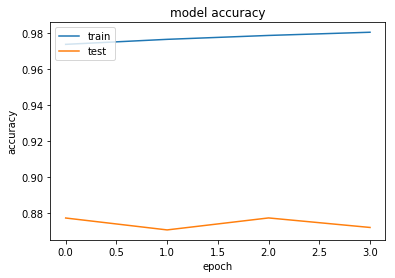

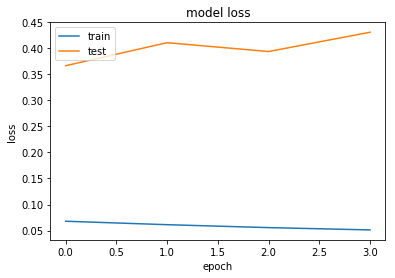

In [200]:
# Visualize training history
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [201]:
model.evaluate(x=cc_test_data, y=cc_test_data_out, batch_size=None, verbose=1, sample_weight=None, steps=None)

8475/8475 [==============================] - 10s 1ms/step


[0.4468569082215121,
 0.6974631269069548,
 0.8684028533426358,
 0.36448377577604446]

In [202]:
model.load_weights("./2xBilstm-02-0.34-0.42.hdf5")

In [203]:
model.evaluate(x=cc_test_data, y=cc_test_data_out, batch_size=None, verbose=1, sample_weight=None, steps=None)

8475/8475 [==============================] - 10s 1ms/step


[0.35202644850300474,
 0.7262536873789311,
 0.8688748288787572,
 0.395634218299635]

In [223]:
pred = model.predict(cc_val_data)

In [224]:
error = cc_val_data_out - pred

In [225]:
import numpy as np

In [226]:
error = np.absolute(error)

In [227]:
error.to_csv('bilstm_error.csv')

In [68]:
!explorer .

In [228]:
error_col_sums = [error[cat].sum() for cat in cc_types]
for cat,err in zip(cc_types,error_col_sums):
    print(cat,err/len(error))

is_anagram 0.2924838497508312
is_homophone 0.03737007524816139
is_double 0.10708915418964644
is_cryptic 0.07456189476353665
is_contain 0.38412872530491493
is_reverse 0.09638247365935372
is_alternate 0.017415237142226387
is_init 0.14328271000384435
is_delete 0.35949966664168426
is_charade 0.41186626313342
is_&lit 0.040231121693441355
is_hidden 0.0556617728000054
is_spoonerism 0.001044038090934796
is_palindrome 0.0017078827505269522


In [83]:
[len(cc_val_df[cc_val_df[cat]==True]) for cat in cc_types]

[9223,
 2491,
 4082,
 2720,
 17709,
 5866,
 733,
 5608,
 11402,
 13779,
 853,
 2852,
 162,
 66]

In [77]:
error.columns

Index(['is_anagram', 'is_homophone', 'is_double', 'is_cryptic', 'is_contain',
       'is_reverse', 'is_alternate', 'is_init', 'is_delete', 'is_charade',
       'is_&lit', 'is_hidden', 'is_spoonerism', 'is_palindrome'],
      dtype='object')

In [78]:
cc_types

['is_anagram',
 'is_homophone',
 'is_double',
 'is_cryptic',
 'is_contain',
 'is_reverse',
 'is_alternate',
 'is_init',
 'is_delete',
 'is_charade',
 'is_&lit',
 'is_hidden',
 'is_spoonerism',
 'is_palindrome']

In [122]:
query = 'Proceeding smoothly and evenly, judge back observing cases'

In [123]:
inpt = pad_sequences(tokenizer.texts_to_sequences([query]),maxlen=15)

In [124]:
preds = model.predict(inpt)

In [125]:
cc_types

['is_anagram',
 'is_homophone',
 'is_double',
 'is_cryptic',
 'is_contain',
 'is_reverse',
 'is_alternate',
 'is_init',
 'is_delete',
 'is_charade',
 'is_&lit',
 'is_hidden',
 'is_spoonerism',
 'is_palindrome']

In [126]:
for a,b in zip(cc_types,preds[0]):
    print(a,b)

is_anagram 0.00080093107
is_homophone 0.001205507
is_double 0.00011718823
is_cryptic 3.4680426e-05
is_contain 0.9938917
is_reverse 0.0020614178
is_alternate 0.9986004
is_init 2.895232e-06
is_delete 0.01853707
is_charade 0.0053280066
is_&lit 3.5364006e-05
is_hidden 0.00079043105
is_spoonerism 1.4816669e-06
is_palindrome 1.3082043e-05


In [229]:
def top_3_accuracy(y_true, y_pred):
    return keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=3)

model = keras.Sequential()
model.add(Embedding(vocab_size, 100,input_length=15,mask_zero=True))
model.add(Bidirectional(LSTM(units=100,dropout=0.5,return_sequences=True)))
model.add(Bidirectional(LSTM(units=100,dropout=0.5,return_sequences=True)))
model.add(Bidirectional(LSTM(units=100,dropout=0.5)))
model.add(Dense(14, activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='RMSProp', metrics=[top_3_accuracy,'accuracy','categorical_accuracy'])

In [230]:
filepath="3xBilstm-{epoch:02d}-{val_loss:.2f}-{val_categorical_accuracy:.2f}.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
callbacks_list = [checkpoint]

In [232]:
history = model.fit(cc_input_data,cc_input_data_out ,validation_data=(cc_val_data,cc_val_data_out), batch_size=1024, epochs=15,callbacks=callbacks_list)

Train on 358484 samples, validate on 16926 samples
Epoch 1/15
358484/358484 [==============================] - 141s 392us/step - loss: 0.3305 - top_3_accuracy: 0.5300 - acc: 0.8643 - categorical_accuracy: 0.3258 - val_loss: 0.2948 - val_top_3_accuracy: 0.5545 - val_acc: 0.8820 - val_categorical_accuracy: 0.3251

Epoch 00001: saving model to 3xBilstm-01-0.29-0.33.hdf5
Epoch 2/15
358484/358484 [==============================] - 140s 391us/step - loss: 0.2609 - top_3_accuracy: 0.6999 - acc: 0.8827 - categorical_accuracy: 0.3732 - val_loss: 0.2899 - val_top_3_accuracy: 0.5534 - val_acc: 0.8663 - val_categorical_accuracy: 0.2043

Epoch 00002: saving model to 3xBilstm-02-0.29-0.20.hdf5
Epoch 3/15
358484/358484 [==============================] - 140s 391us/step - loss: 0.2123 - top_3_accuracy: 0.7720 - acc: 0.9037 - categorical_accuracy: 0.4138 - val_loss: 0.2865 - val_top_3_accuracy: 0.6453 - val_acc: 0.8733 - val_categorical_accuracy: 0.3154

Epoch 00003: saving model to 3xBilstm-03-0.29-0.

In [233]:
import pickle
with open('./3xBilstmHistory', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

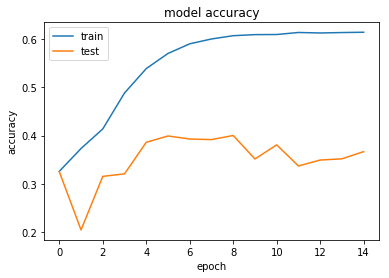

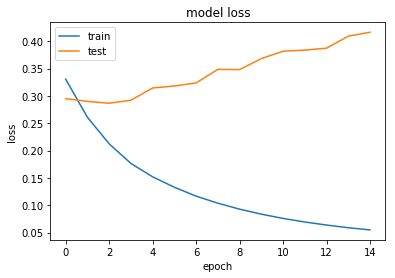

In [235]:
# Visualize training history
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

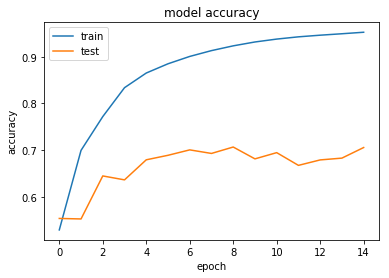

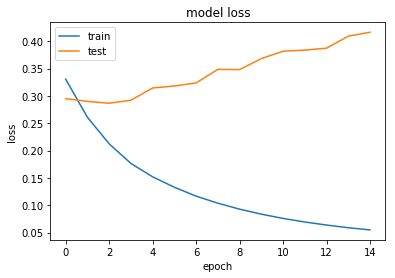

In [236]:
# Visualize training history
# summarize history for accuracy
plt.plot(history.history['top_3_accuracy'])
plt.plot(history.history['val_top_3_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [238]:
model.load_weights("./3xBilstm-09-0.35-0.40.hdf5")

In [239]:
model.evaluate(x=cc_test_data, y=cc_test_data_out, batch_size=None, verbose=1, sample_weight=None, steps=None)

8475/8475 [==============================] - 15s 2ms/step


[0.35682671900695756,
 0.695457227223039,
 0.8662452500267367,
 0.3838348082912355]

In [240]:
pred = model.predict(cc_val_data)
error = cc_val_data_out - pred
error = np.absolute(error)
error_col_sums = [error[cat].sum() for cat in cc_types]
for cat,err in zip(cc_types,error_col_sums):
    print(cat,err/len(error))

is_anagram 0.27134508811291974
is_homophone 0.03939075873617451
is_double 0.12846538594596674
is_cryptic 0.07140522638860179
is_contain 0.3844037081804604
is_reverse 0.10374778863039356
is_alternate 0.015119418038496854
is_init 0.1409753661600937
is_delete 0.3709257346433262
is_charade 0.423911651140193
is_&lit 0.02586975332928806
is_hidden 0.07024161006097804
is_spoonerism 0.0011445446166587546
is_palindrome 0.0011181712882566018
